In [1]:
import numpy as np
import pandas as pd
import torch
from gensim.models import Word2Vec

# Autoreload extensions
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
word2VecModel =  Word2Vec.load("./project/models/word2vec100.model")
#print embedding dimensions
EMBEDDING_SIZE = word2VecModel.wv.vectors.shape[1]
print(f"EMBEDDING_SIZE: {EMBEDDING_SIZE}")
print(f"Vocab Size: {word2VecModel.wv.vectors.shape[0]}")

EMBEDDING_SIZE: 100
Vocab Size: 1912


In [4]:
import sqlite3

In [5]:
connection = sqlite3.connect('./chess_games.db')
cursor = connection.cursor()

In [6]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

for table_name in tables:
    table_name = table_name[0]
    print(f"Schema for table: {table_name}")
    cursor.execute(f"PRAGMA table_info({table_name});")
    schema = cursor.fetchall()
    for column in schema:
        print(column)
    print("-" * 40)

Schema for table: games
(0, 'id', 'INTEGER', 0, None, 1)
(1, 'result', 'TEXT', 0, None, 0)
(2, 'termination', 'TEXT', 0, None, 0)
----------------------------------------
Schema for table: moves
(0, 'id', 'INTEGER', 0, None, 1)
(1, 'game_id', 'INTEGER', 0, None, 0)
(2, 'move_number', 'INTEGER', 0, None, 0)
(3, 'move', 'TEXT', 0, None, 0)
(4, 'board_fen', 'TEXT', 0, None, 0)
----------------------------------------
Schema for table: pieces
(0, 'game_id', 'INTEGER', 0, None, 1)
(1, 'move_number', 'INTEGER', 0, None, 2)
(2, 'piece', 'TEXT', 0, None, 0)
(3, 'captured', 'TEXT', 0, None, 0)
----------------------------------------


In [7]:
df_games = pd.read_sql_query("SELECT id, result FROM games", connection)
df_games.head()

,id,result
0,1,1/2-1/2
1,2,1-0
2,3,1/2-1/2
3,4,1-0
4,5,1-0


In [8]:
df_moves = pd.read_sql_query("SELECT game_id, move_number, move FROM moves", connection)
df_moves.head()

,game_id,move_number,move
0,1,1,d2d4
1,1,2,f7f5
2,1,3,g2g3
3,1,4,g7g6
4,1,5,f1g2


In [9]:
# group by game_id
df_moves_grouped = df_moves.groupby('game_id')['move'].apply(list).reset_index()
df_moves_grouped.head()

,game_id,move
0,1,"[d2d4, f7f5, g2g3, g7g6, f1g2, f8g7, g1f3, d7d..."
1,2,"[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, c7c..."
2,3,"[d2d4, g8f6, c2c4, e7e5, d4e5, f6g4, c1f4, b8c..."
3,4,"[c2c4, g8f6, b1c3, e7e5, g2g3, g7g6, f1g2, f8g..."
4,5,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, c7c..."


In [10]:
len(df_moves_grouped) == len(df_games)

True

In [11]:
# Joinn the dfs by game_id
df_merged = pd.merge(df_moves_grouped, df_games, left_on='game_id', right_on='id', how='left').drop(columns=['id', 'game_id'])
df_merged.head()

,move,result
0,"[d2d4, f7f5, g2g3, g7g6, f1g2, f8g7, g1f3, d7d...",1/2-1/2
1,"[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, c7c...",1-0
2,"[d2d4, g8f6, c2c4, e7e5, d4e5, f6g4, c1f4, b8c...",1/2-1/2
3,"[c2c4, g8f6, b1c3, e7e5, g2g3, g7g6, f1g2, f8g...",1-0
4,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, c7c...",1-0


In [99]:
#One hot encoding the result column
one_hot = pd.get_dummies(df_merged['result'])
df_one_hot = df_merged.copy()
# Collect the dummies as a list of bools in a new column
df_one_hot['one_hot_encodings'] = one_hot.values.tolist()
# Drop the original result column
df_one_hot.head()

,move,result,one_hot_encodings
0,"[d2d4, f7f5, g2g3, g7g6, f1g2, f8g7, g1f3, d7d...",1/2-1/2,"[False, False, True]"
1,"[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, c7c...",1-0,"[False, True, False]"
2,"[d2d4, g8f6, c2c4, e7e5, d4e5, f6g4, c1f4, b8c...",1/2-1/2,"[False, False, True]"
3,"[c2c4, g8f6, b1c3, e7e5, g2g3, g7g6, f1g2, f8g...",1-0,"[False, True, False]"
4,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, c7c...",1-0,"[False, True, False]"


In [100]:
# Cross validation split the dataset
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_one_hot, test_size=0.2, random_state=42)
df_train, df_val  = train_test_split(df_train, test_size=0.2, random_state=42)
df_train.shape, df_val.shape, df_test.shape

((64000, 3), (16000, 3), (20000, 3))

In [101]:
from torch.utils.data import Dataset, DataLoader
from typing import Dict

class OutcomeClassificationDataset(Dataset):
    def __init__(self, data, word2VecModel:Word2Vec):
        self.data = data
        self.word2VecModel:Word2Vec = word2VecModel

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sent = self.data[idx]['move']
        # words = [self.word2VecModel.wv[token] if token in self.word2VecModel.wv.key_to_index else np.zeros(EMBEDDING_SIZE) for token in sent]
        words = [self.word2VecModel.wv[token] if token in self.word2VecModel.wv.key_to_index else np.zeros(EMBEDDING_SIZE) for token in sent]
        label = self.data[idx]['one_hot_encodings']
        return torch.tensor(words, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)
    
dataset_train = OutcomeClassificationDataset(df_train.to_dict(orient='records'), word2VecModel)
dataset_val = OutcomeClassificationDataset(df_val.to_dict(orient='records'), word2VecModel)
dataset_test = OutcomeClassificationDataset(df_test.to_dict(orient='records'), word2VecModel)

In [102]:
dataset_test[0][0].shape, dataset_test[0][1].shape

(torch.Size([163, 100]), torch.Size([3]))

In [103]:
def collate_fn(batch):
    # batch: list of tuples (word_tensor, tag_tensor)
    # Get input sentences
    moves = [item[0] for item in batch]
    # Get labels
    outcomes = [item[1] for item in batch]
    # Get maximum length in the batch
    lengths = [len(s) for s in moves]
    max_len = max(lengths)

    # Pad shorter sentences to let the input tensors all have the same size
    padded_moves = []
    for s in moves:
        pad_len = max_len - len(s)
        # Padding uses index 0 both for words and labels
        padded_moves.append(torch.cat([s, torch.zeros((pad_len, s.shape[1]), dtype=torch.float32)]))

    #
    return torch.stack(padded_moves), torch.stack(outcomes), lengths

BATCH_SIZE = 8
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [104]:
for batch in train_loader:
    moves, outcomes, lengths = batch
    print("Moves shape:", moves.shape)
    print("Outcomes shape:", outcomes.shape)
    print("Lengths:", lengths)
    break

Moves shape: torch.Size([8, 187, 100])
Outcomes shape: torch.Size([8, 3])
Lengths: [75, 169, 108, 95, 167, 155, 107, 187]


In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [106]:
class BiLSTM_NER(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_outcomes):
        super(BiLSTM_NER, self).__init__()
        # Bidirectional LSTM; we set batch_first=True to have input like [batch, seq_len, embedding_dim]
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        # Fully connected layer to map hidden state coming from LSTM to output labels
        # (the hidden state is a concatenation of two LSTM outputs since it is bidirectional)
        self.fc = nn.Linear(hidden_dim * 2, num_outcomes)

    def forward(self, x):
        # x: [batch_size, seq_len]
        lstm_out, _ = self.lstm(x)   # lstm_out: [batch_size, seq_len, hidden_dim*2]
        logits = self.fc(lstm_out[:, -1, :])        # logits: [batch_size, seq_len, num_tags]
        probabs = torch.nn.functional.softmax(logits, dim=-1)  # probabs: [batch_size, seq_len, num_tags]
        return probabs

In [107]:
# Parametri del modello
HIDDEN_DIM = 128
EPOCHS = 10

In [108]:
model = BiLSTM_NER(EMBEDDING_SIZE, HIDDEN_DIM, 3)

In [109]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [110]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [111]:
model = model.to(device)

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, recall_score, f1_score

history = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0
    for inputs, targets, lengths in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.view(-1, 3)
        targets = torch.argmax(targets, dim=-1) ##
        #targets = targets.view(-1)
        loss = criterion.forward(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        history.append(loss.item())
    avg_train_loss = epoch_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_true = []
    with torch.no_grad():
        for inputs, targets, lengths in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.view(-1, 3)
            targets = targets.view(-1, 3)
            loss = criterion(outputs, torch.argmax(targets, dim=-1))
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            true = torch.argmax(targets, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(true)
    avg_val_loss = val_loss / len(val_loader)

    # Compute metrics
    val_accuracy = accuracy_score(all_true, all_preds)
    val_recall = recall_score(all_true, all_preds, average='weighted')
    val_f1 = f1_score(all_true, all_preds, average='weighted')

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.4f} - Val Recall: {val_recall:.4f} - Val F1: {val_f1:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            model.load_state_dict(best_model_state)
            break

  6%|▌         | 460/8000 [00:14<04:01, 31.26it/s]

In [ ]:
historyReshaped = np.array(history).reshape(-1, len(train_loader))
print(historyReshaped.shape)

(10, 8000)


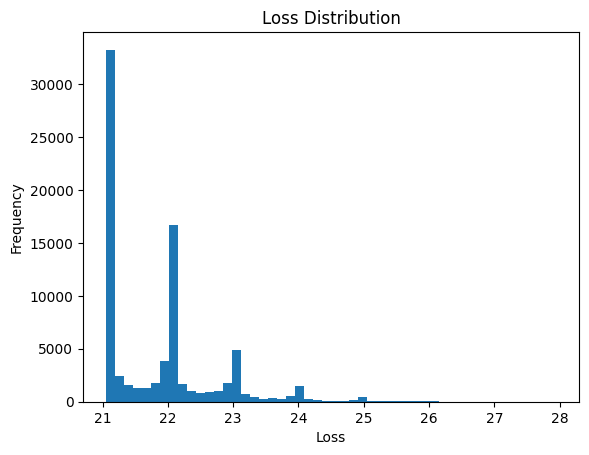

In [ ]:
# plot the distribution of the loss
import matplotlib.pyplot as plt

plt.hist(history[:-1], bins=50)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss Distribution')
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    # Get the first 10 samples from the validation set
    sample_batch = [dataset_val[i] for i in range(10)]
    moves, outcomes, lengths = collate_fn(sample_batch)
    moves = moves.to(device)
    outputs = model(moves)
    preds = outputs.cpu().numpy()
    true_labels = torch.argmax(outcomes, dim=1).numpy()
    print("Predictions:", preds)
    print("True labels:", true_labels)

Predictions: [[9.9986410e-01 1.1976578e-04 1.6119329e-05]
 [9.8178631e-01 3.3356673e-03 1.4877954e-02]
 [9.9997878e-01 3.9617944e-06 1.7328435e-05]
 [5.7009085e-11 3.0918339e-09 1.0000000e+00]
 [4.0642038e-01 5.9333920e-01 2.4044620e-04]
 [5.7048567e-11 3.0924590e-09 1.0000000e+00]
 [6.2929949e-08 9.9999988e-01 2.4011713e-09]
 [2.6170196e-07 9.9999976e-01 1.0728981e-08]
 [1.3491077e-05 6.6290498e-09 9.9998653e-01]
 [5.1923575e-08 9.9999988e-01 6.9050337e-08]]
True labels: [0 1 0 2 1 2 1 1 2 1]


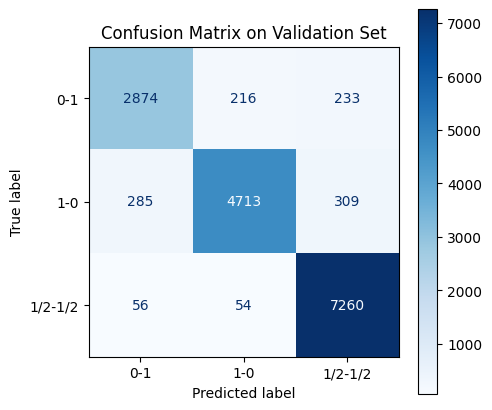

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import matplotlib.pyplot as plt

# Get predictions and true labels for the entire validation set
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for inputs, targets, lengths in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = torch.argmax(targets, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(true)

cm = confusion_matrix(all_true, all_preds)
labels = ['0-1', '1-0', '1/2-1/2']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Validation Set")
plt.show()

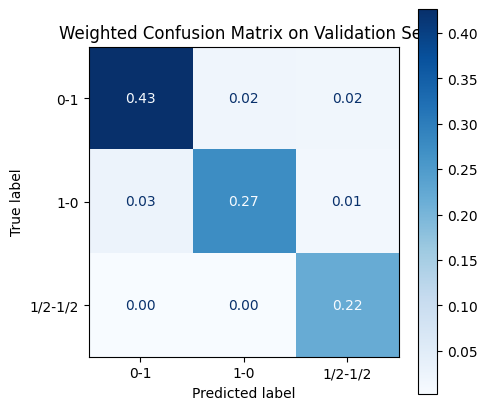

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Plot a weighted confusion matrix
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_true), y=all_true)
# Normalize weights for display
norm_weights = class_weights / class_weights.sum()
norm_weights = norm_weights[:, np.newaxis]  # Reshape to 2D for display

norm_weights_matrix = norm_weights @ norm_weights.T

cm_weighted = cm * norm_weights_matrix
cm_weighted = cm_weighted.astype('float') / cm_weighted.sum()

# Plot weighted confusion matrix
fig, ax = plt.subplots(figsize=(5,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title("Weighted Confusion Matrix on Validation Set")
plt.show()

In [ ]:
print("Sum of diagonal of weighted confusion matrix:", np.trace(cm_weighted))

Sum of diagonal of weighted confusion matrix: 0.9189691312029433


              precision    recall  f1-score   support

         0-1       0.89      0.86      0.88      3323
         1-0       0.95      0.89      0.92      5307
     1/2-1/2       0.93      0.99      0.96      7370

    accuracy                           0.93     16000
   macro avg       0.92      0.91      0.92     16000
weighted avg       0.93      0.93      0.93     16000



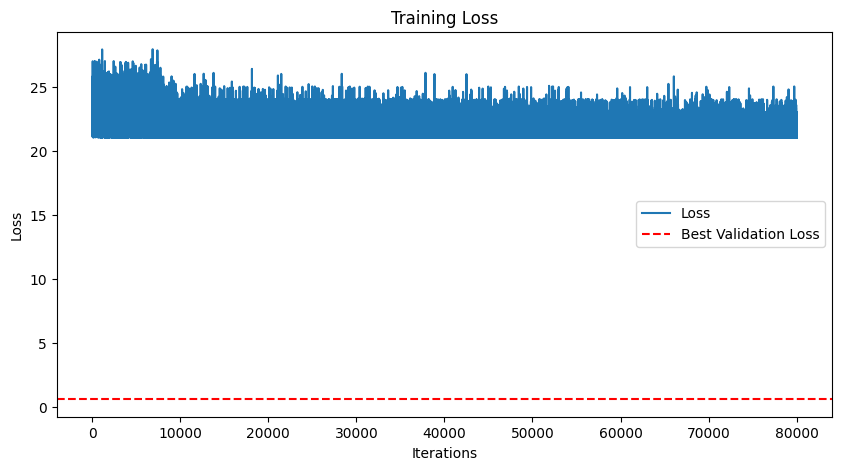

In [ ]:
#Comupte accuracy, recall and f1 score on validation set
from sklearn.metrics import classification_report
report = classification_report(all_true, all_preds, target_names=labels)
print(report)

# Plot the metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history, label='Loss')

plt.axhline(y=best_val_loss, color='r', linestyle='--', label='Best Validation Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'bilstm_model.pth')

# Classification of the outcome cause

In [ ]:
df_cause = pd.read_sql_query("SELECT id, termination FROM games", connection)

In [ ]:
df_cause.head()

,id,termination
0,1,FIVEFOLD_REPETITION
1,2,CHECKMATE
2,3,INSUFFICIENT_MATERIAL
3,4,CHECKMATE
4,5,CHECKMATE


In [ ]:
df_moves_grouped.head()

,game_id,move
0,1,"[d2d4, f7f5, g2g3, g7g6, f1g2, f8g7, g1f3, d7d..."
1,2,"[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, c7c..."
2,3,"[d2d4, g8f6, c2c4, e7e5, d4e5, f6g4, c1f4, b8c..."
3,4,"[c2c4, g8f6, b1c3, e7e5, g2g3, g7g6, f1g2, f8g..."
4,5,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, c7c..."


In [ ]:
df_moves_cause = pd.merge(df_moves_grouped, df_cause, left_on='game_id', right_on='id', how='left').drop(columns=['id', 'game_id'])
df_moves_cause.head()

,move,termination
0,"[d2d4, f7f5, g2g3, g7g6, f1g2, f8g7, g1f3, d7d...",FIVEFOLD_REPETITION
1,"[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, c7c...",CHECKMATE
2,"[d2d4, g8f6, c2c4, e7e5, d4e5, f6g4, c1f4, b8c...",INSUFFICIENT_MATERIAL
3,"[c2c4, g8f6, b1c3, e7e5, g2g3, g7g6, f1g2, f8g...",CHECKMATE
4,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, c7c...",CHECKMATE


In [ ]:
# One hot encoding the termination column
one_hot_termination = pd.get_dummies(df_moves_cause['termination'])
df_cause_one_hot = df_moves_cause.copy()
df_cause_one_hot['one_hot_termination'] = one_hot_termination.values.tolist()
# drop the termination column
df_cause_one_hot = df_cause_one_hot.drop(columns=['termination'])
df_cause_one_hot.head()

,move,one_hot_termination
0,"[d2d4, f7f5, g2g3, g7g6, f1g2, f8g7, g1f3, d7d...","[False, True, False, False, False]"
1,"[e2e4, e7e6, d2d4, d7d5, b1c3, f8b4, e4e5, c7c...","[True, False, False, False, False]"
2,"[d2d4, g8f6, c2c4, e7e5, d4e5, f6g4, c1f4, b8c...","[False, False, True, False, False]"
3,"[c2c4, g8f6, b1c3, e7e5, g2g3, g7g6, f1g2, f8g...","[True, False, False, False, False]"
4,"[d2d4, g8f6, c2c4, e7e6, b1c3, f8b4, d1c2, c7c...","[True, False, False, False, False]"


In [ ]:
# Cross validation split the dataset
from sklearn.model_selection import train_test_split
df_train_cause, df_test_cause = train_test_split(df_cause_one_hot, test_size=0.2, random_state=42)
df_train_cause, df_val_cause  = train_test_split(df_train_cause, test_size=0.2, random_state=42)
df_train_cause.shape, df_val_cause.shape, df_test_cause.shape

((64000, 2), (16000, 2), (20000, 2))